# Torch NN and Hugging Face model on the Doodle Dataset

In [24]:
# import standard libraries
import os
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# hugging face libraries for classification
import torch
import torchvision.transforms as transforms
import ast
import cv2
from PIL import Image
from datasets import Dataset
from transformers import ViTFeatureExtractor
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
from datasets import Dataset, DatasetDict

In [25]:
# loading the csv file from the folder 

df = pl.read_csv("/media/parker/Data_Drive/quick-draw-data/master_doodle_dataframe.csv")

In [26]:
df.head()

countrycode,drawing,key_id,recognized,word,image_path
str,str,i64,bool,str,str
"""RO""","""[[[0, 5, 3, 4, 10, 72, 82, 91,…",5613582005829632,true,"""traffic light""","""data/traffic light/56135820058…"
"""US""","""[[[0, 255], [3, 4]], [[86, 73,…",5769631006457856,true,"""traffic light""","""data/traffic light/57696310064…"
"""ZA""","""[[[39, 33, 34, 39, 52, 61, 66,…",4999795544424448,true,"""traffic light""","""data/traffic light/49997955444…"
"""VN""","""[[[12, 9], [128, 255]], [[0, 2…",4878417906368512,true,"""traffic light""","""data/traffic light/48784179063…"
"""HU""","""[[[9, 7, 0, 19, 49, 90, 96, 99…",5572841187573760,true,"""traffic light""","""data/traffic light/55728411875…"


In [27]:
# convert the polars dataframe to pandas dataframe

df = df.to_pandas()

In [28]:
# dropping the countrycode column, reconized, and the imagepath columns 
df = df.drop(columns=['countrycode', 'recognized', 'key_id', 'image_path'])

In [29]:
df.columns

Index(['drawing', 'word'], dtype='object')

In [ ]:
# saving the unique values from the word column to a csv so we can specify the classess that we want to use

words = df['word'].unique()
print(words)


['traffic light' 'rhinoceros' 'bed' 'school bus' 'van' 'octopus'
 'firetruck' 'laptop' 'tractor' 'matches' 'windmill' 'square' 'pineapple'
 'candle' 'mosquito' 'pear' 'boomerang' 'lollipop' 'yoga' 'waterslide'
 'swan' 'triangle' 'diving board' 'crayon' 'hockey puck' 'moustache'
 'calendar' 'cow' 'fire hydrant' 'hot air balloon' 'helmet' 'parrot'
 'hot tub' 'baseball' 'saw' 'mouth' 'passport' 'campfire' 'car'
 'bulldozer' 'pencil' 'wine glass' 'marker' 'axe' 'mug' 'see saw' 'foot'
 'door' 'beach' 'cruise ship' 'drums' 'necklace' 'spoon' 'motorbike'
 'megaphone' 'penguin' 'washing machine' 'giraffe' 'monkey' 'shoe'
 'microphone' 'skyscraper' 'blackberry' 'sword' 'nail' 'birthday cake'
 'carrot' 'lobster' 'hourglass' 'microwave' 'cannon' 'clarinet'
 'basketball' 'pliers' 'bee' 'flashlight' 'leaf' 'belt' 'grass' 'river'
 'peas' 'elbow' 'tiger' 'roller coaster' 'piano' 'trumpet' 'snowflake'
 'bandage' 'bowtie' 'harp' 'onion' 'stairs' 'bus' 'oven' 'stop sign'
 'chair' 'guitar' 'headphones' '

In [31]:
# saving the words to a csv file
words_df = pd.DataFrame(words)
# setting the words df to a csv file for filtering and picking the better ones
words_df.to_csv('words.csv', index=False)

In [32]:
# loading up words again from the csv file
words = pd.read_csv('words copy.csv')

In [33]:
words.head()

,words
0,traffic light
1,van
2,firetruck
3,tractor
4,windmill


In [34]:
# removing all null values from the dataframe
words = words.dropna()

In [35]:
# saving the words to a json file, so later we can load it up as a list
words.to_json('words.json', orient='records')

In [36]:
# load words and make a list
words = pd.read_json('words.json')
words = words['words']

In [37]:
# filter the data frame now
df = df[df['word'].isin(words)]
print(df['word'].unique())

['traffic light' 'van' 'firetruck' 'tractor' 'windmill' 'waterslide'
 'swan' 'moustache' 'cow' 'hot air balloon' 'saw' 'campfire' 'car'
 'bulldozer' 'axe' 'see saw' 'door' 'beach' 'motorbike' 'skyscraper'
 'sword' 'cannon' 'grass' 'river' 'peas' 'piano' 'trumpet' 'bandage'
 'stairs' 'oven' 'stop sign' 'sheep' 'cell phone' 'stitches' 'police car'
 'jail' 'ocean' 'telephone' 'bush' 'barn' 'cactus' 'sun' 'radio'
 'lighthouse' 'sleeping bag' 'baseball bat' 'hammer' 'cloud' 'frying pan'
 'teapot' 'compass' 'backpack' 'speedboat' 'skull' 'tree' 'camouflage'
 'pickup truck' 'castle' 'binoculars' 'helicopter' 'flying saucer'
 't-shirt' 'hospital' 'lightning' 'bridge' 'ambulance' 'stereo' 'snake'
 'submarine' 'mountain' 'dumbbell' 'airplane' 'shovel']


In [38]:
# filter down the selection even further using a list
words_keep = ['traffic light', 'van', 'firetruck', 'tractor', 'axe', 'motorbike', 'skyscraper',
              'sword', 'cannon', 'grass', 'river', 'jail', 'telephone', 'radio',
              'baseball bat', 'hammer', 'cloud', 'backpack', 'speedboat', 'skull', 'snake',
              'submarine']



# submarine = bad ~ 0
# grass = good ~ 1 

'''

EXAMPLE 
0 = axe 
1 = river 
0 = sub 
1 = grass 


#                   0    0    0 - axe ppl
start point - x     0    1 -> 0 - zombie      y - end point  
#                \  1 /  0    0 - bomb


'''

# filter the dataframe even more 
df = df[df['word'].isin(words_keep)]

In [39]:
# making words to keep a df 
words_keep_df = pd.DataFrame(words_keep)
words_keep_df.head()

,0
0,traffic light
1,van
2,firetruck
3,tractor
4,axe


In [40]:
# making words the column header 
words_keep_df.columns = ['word']
words_keep_df.head()

,word
0,traffic light
1,van
2,firetruck
3,tractor
4,axe


In [41]:
# SAVING THE WORDS TO A json  FILE

words_keep_df = pd.DataFrame(words_keep)

# Convert list to DataFrame with correct column name
words_keep_df = pd.DataFrame(words_keep, columns=['words'])

# Save to JSON with correct formatting
words_keep_df.to_json('words_keep.json', orient='records', indent=4)

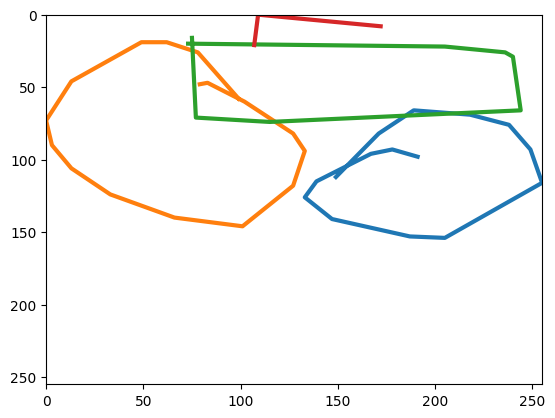

In [42]:
import ast  

# random drawing 
image_data = df['drawing'].iloc[10000]

# convert the string to a list 
if isinstance(image_data, str):  
    image_data = ast.literal_eval(image_data) 

# creating a blank canvas to plot
fig, ax = plt.subplots()
ax.set_xlim(0, 255)
ax.set_ylim(0, 255)
ax.invert_yaxis()  

# drawing the image
for stroke in image_data:
    x, y = stroke  
    ax.plot(x, y, linewidth=3)

plt.show()


In [43]:
df.columns

Index(['drawing', 'word'], dtype='object')

In [44]:
# printing the count of the distinct words in the 'word' column
count_classes = df['word'].value_counts()
print(count_classes)

word
traffic light    3000
van              3000
snake            3000
skull            3000
speedboat        3000
backpack         3000
cloud            3000
hammer           3000
baseball bat     3000
radio            3000
telephone        3000
jail             3000
river            3000
grass            3000
cannon           3000
sword            3000
skyscraper       3000
motorbike        3000
axe              3000
tractor          3000
firetruck        3000
submarine        3000
Name: count, dtype: int64


In [45]:
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [46]:
# print the device name
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2060


In [47]:
# defined the fixed lengths of the arrays, this in term also limits our image size
FIXED_LENGTH = 2048  

# Function to convert stroke data to a fixed-size numpy array, which is like the MNIST dataset
def strokes_to_array(strokes, max_length=FIXED_LENGTH):
    points = []
    
    for stroke in strokes:
        x, y = stroke
        points.extend(list(zip(x, y)))

    # Flatten list of tuples into 1D array
    points = np.array(points).flatten()

    # normalize values between -1 and 1 (right here I am making the image like MNIST dataset)
    points = points / 255.0  

    # pad with zeros if too short, truncate if too long
    if len(points) < max_length:
        points = np.pad(points, (0, max_length - len(points)), 'constant')
    else:
        points = points[:max_length]

    return points

# apply the transformation to the dataset
df['drawing_array'] = df['drawing'].apply(lambda x: strokes_to_array(ast.literal_eval(x)))

In [48]:
from torch.utils.data import Dataset, DataLoader

# convert labels to numeric format
word_to_idx = {word: idx for idx, word in enumerate(df['word'].unique())}
df['label'] = df['word'].map(word_to_idx)

# custom torch dataset class 
class QuickDrawDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data.iloc[idx]['drawing_array'], dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx]['label'], dtype=torch.long)
        return x, y

# create dataset and dataloader for torch
dataset = QuickDrawDataset(df)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

### Torch Imports

In [49]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [50]:
# Define an MLP model
import torch.nn as nn

class LargeQuickDrawCNN(nn.Module):
    def __init__(self, num_classes):
        super(LargeQuickDrawCNN, self).__init__()

        # convolutional layers (increased depth from last itteration)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  
        
        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully connected Layers (made the network network)
        self.fc1 = nn.Linear(512 * 2 * 4, 1024)  
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

        # batch normalization
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)

        # dropout 
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # reshaping
        x = x.view(-1, 1, 32, 64)  

        # convolutional layers with BatchNorm, activation & pooling
        x = self.pool(F.leaky_relu(self.batchnorm1(self.conv1(x)), negative_slope=0.1))
        x = self.pool(F.leaky_relu(self.batchnorm2(self.conv2(x)), negative_slope=0.1))
        x = self.pool(F.leaky_relu(self.batchnorm3(self.conv3(x)), negative_slope=0.1))
        x = self.pool(F.leaky_relu(self.batchnorm4(self.conv4(x)), negative_slope=0.1))

        # flatten before FC layers
        x = x.view(x.size(0), -1)

        # fully Connected Layers + Dropout
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = self.fc3(x)

        return x

# init model to GPU 
num_classes = len(word_to_idx)
model = LargeQuickDrawCNN(num_classes).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


# init the loss funct and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# for plotting and metrics
train_losses = []
train_accuracies = []
val_accuracies = []

# split data for training and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [51]:
# training 
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=True)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # tracking loss
        running_loss += loss.item()

        # compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # progress bar 
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    # store metrics
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # validation 
    model.eval()
    val_correct = 0
    val_total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            # store true and predicted labels for metrics
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)

    # calc precision, recall, f1
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

print("Training Complete!")

Epoch [1/30]: 100%|██████████| 825/825 [00:19<00:00, 41.50it/s, acc=32.3, loss=1.35]


Epoch [1/30] - Loss: 2.1446, Train Acc: 32.32%, Val Acc: 48.88%
Precision: 0.5568, Recall: 0.4879, F1-score: 0.4758


Epoch [2/30]: 100%|██████████| 825/825 [00:19<00:00, 42.96it/s, acc=60.4, loss=0.992]


Epoch [2/30] - Loss: 1.2325, Train Acc: 60.37%, Val Acc: 67.40%
Precision: 0.7021, Recall: 0.6746, F1-score: 0.6758


Epoch [3/30]: 100%|██████████| 825/825 [00:19<00:00, 42.92it/s, acc=70.6, loss=0.752]


Epoch [3/30] - Loss: 0.9004, Train Acc: 70.57%, Val Acc: 74.61%
Precision: 0.7605, Recall: 0.7461, F1-score: 0.7432


Epoch [4/30]: 100%|██████████| 825/825 [00:19<00:00, 43.32it/s, acc=76.3, loss=0.865]


Epoch [4/30] - Loss: 0.7220, Train Acc: 76.25%, Val Acc: 75.63%
Precision: 0.7795, Recall: 0.7566, F1-score: 0.7547


Epoch [5/30]: 100%|██████████| 825/825 [00:19<00:00, 43.20it/s, acc=80, loss=0.531]  


Epoch [5/30] - Loss: 0.6054, Train Acc: 79.97%, Val Acc: 79.39%
Precision: 0.8059, Recall: 0.7944, F1-score: 0.7944


Epoch [6/30]: 100%|██████████| 825/825 [00:19<00:00, 43.23it/s, acc=82.8, loss=0.361]


Epoch [6/30] - Loss: 0.5134, Train Acc: 82.78%, Val Acc: 80.43%
Precision: 0.8149, Recall: 0.8055, F1-score: 0.8025


Epoch [7/30]: 100%|██████████| 825/825 [00:19<00:00, 43.30it/s, acc=85.1, loss=0.352]


Epoch [7/30] - Loss: 0.4375, Train Acc: 85.07%, Val Acc: 82.29%
Precision: 0.8312, Recall: 0.8219, F1-score: 0.8218


Epoch [8/30]: 100%|██████████| 825/825 [00:19<00:00, 43.36it/s, acc=87, loss=0.472]  


Epoch [8/30] - Loss: 0.3766, Train Acc: 87.03%, Val Acc: 83.83%
Precision: 0.8440, Recall: 0.8386, F1-score: 0.8394


Epoch [9/30]: 100%|██████████| 825/825 [00:19<00:00, 43.22it/s, acc=89, loss=0.334]   


Epoch [9/30] - Loss: 0.3251, Train Acc: 88.95%, Val Acc: 83.09%
Precision: 0.8324, Recall: 0.8308, F1-score: 0.8298


Epoch [10/30]: 100%|██████████| 825/825 [00:19<00:00, 43.39it/s, acc=90.1, loss=0.244] 


Epoch [10/30] - Loss: 0.2852, Train Acc: 90.08%, Val Acc: 83.90%
Precision: 0.8438, Recall: 0.8390, F1-score: 0.8391


Epoch [11/30]: 100%|██████████| 825/825 [00:18<00:00, 43.54it/s, acc=91.5, loss=0.22]  


Epoch [11/30] - Loss: 0.2475, Train Acc: 91.53%, Val Acc: 83.98%
Precision: 0.8453, Recall: 0.8398, F1-score: 0.8404


Epoch [12/30]: 100%|██████████| 825/825 [00:18<00:00, 43.57it/s, acc=92.6, loss=0.404] 


Epoch [12/30] - Loss: 0.2107, Train Acc: 92.62%, Val Acc: 83.42%
Precision: 0.8433, Recall: 0.8351, F1-score: 0.8343


Epoch [13/30]: 100%|██████████| 825/825 [00:19<00:00, 43.32it/s, acc=93.5, loss=0.305] 


Epoch [13/30] - Loss: 0.1817, Train Acc: 93.53%, Val Acc: 84.52%
Precision: 0.8492, Recall: 0.8454, F1-score: 0.8448


Epoch [14/30]: 100%|██████████| 825/825 [00:19<00:00, 43.00it/s, acc=94.3, loss=0.247] 


Epoch [14/30] - Loss: 0.1681, Train Acc: 94.34%, Val Acc: 84.73%
Precision: 0.8498, Recall: 0.8472, F1-score: 0.8471


Epoch [15/30]: 100%|██████████| 825/825 [00:19<00:00, 42.75it/s, acc=94.8, loss=0.14]   


Epoch [15/30] - Loss: 0.1505, Train Acc: 94.79%, Val Acc: 84.27%
Precision: 0.8478, Recall: 0.8431, F1-score: 0.8430


Epoch [16/30]: 100%|██████████| 825/825 [00:19<00:00, 42.56it/s, acc=95.3, loss=0.171] 


Epoch [16/30] - Loss: 0.1358, Train Acc: 95.27%, Val Acc: 84.77%
Precision: 0.8519, Recall: 0.8472, F1-score: 0.8475


Epoch [17/30]: 100%|██████████| 825/825 [00:18<00:00, 43.58it/s, acc=95.5, loss=0.095]  


Epoch [17/30] - Loss: 0.1271, Train Acc: 95.55%, Val Acc: 84.18%
Precision: 0.8458, Recall: 0.8414, F1-score: 0.8418


Epoch [18/30]: 100%|██████████| 825/825 [00:18<00:00, 43.63it/s, acc=96, loss=0.12]     


Epoch [18/30] - Loss: 0.1161, Train Acc: 96.05%, Val Acc: 84.45%
Precision: 0.8482, Recall: 0.8445, F1-score: 0.8445


Epoch [19/30]: 100%|██████████| 825/825 [00:19<00:00, 43.37it/s, acc=96.1, loss=0.0882] 


Epoch [19/30] - Loss: 0.1144, Train Acc: 96.11%, Val Acc: 84.63%
Precision: 0.8511, Recall: 0.8459, F1-score: 0.8458


Epoch [20/30]: 100%|██████████| 825/825 [00:18<00:00, 43.43it/s, acc=96.3, loss=0.141]  


Epoch [20/30] - Loss: 0.1086, Train Acc: 96.30%, Val Acc: 83.80%
Precision: 0.8445, Recall: 0.8379, F1-score: 0.8385


Epoch [21/30]: 100%|██████████| 825/825 [00:19<00:00, 43.18it/s, acc=96.9, loss=0.125]  


Epoch [21/30] - Loss: 0.0935, Train Acc: 96.93%, Val Acc: 84.52%
Precision: 0.8487, Recall: 0.8454, F1-score: 0.8453


Epoch [22/30]: 100%|██████████| 825/825 [00:19<00:00, 42.79it/s, acc=96.7, loss=0.148]  


Epoch [22/30] - Loss: 0.0991, Train Acc: 96.70%, Val Acc: 84.00%
Precision: 0.8515, Recall: 0.8398, F1-score: 0.8414


Epoch [23/30]: 100%|██████████| 825/825 [00:19<00:00, 43.09it/s, acc=97.1, loss=0.0651] 


Epoch [23/30] - Loss: 0.0880, Train Acc: 97.08%, Val Acc: 84.42%
Precision: 0.8486, Recall: 0.8444, F1-score: 0.8440


Epoch [24/30]: 100%|██████████| 825/825 [00:19<00:00, 42.95it/s, acc=97, loss=0.0434]   


Epoch [24/30] - Loss: 0.0907, Train Acc: 97.01%, Val Acc: 83.89%
Precision: 0.8421, Recall: 0.8388, F1-score: 0.8374


Epoch [25/30]: 100%|██████████| 825/825 [00:19<00:00, 43.33it/s, acc=97.2, loss=0.022]  


Epoch [25/30] - Loss: 0.0845, Train Acc: 97.23%, Val Acc: 85.11%
Precision: 0.8564, Recall: 0.8508, F1-score: 0.8518


Epoch [26/30]: 100%|██████████| 825/825 [00:19<00:00, 43.23it/s, acc=97.5, loss=0.119]  


Epoch [26/30] - Loss: 0.0774, Train Acc: 97.49%, Val Acc: 84.31%
Precision: 0.8488, Recall: 0.8434, F1-score: 0.8442


Epoch [27/30]: 100%|██████████| 825/825 [00:19<00:00, 43.41it/s, acc=97.3, loss=0.0704] 


Epoch [27/30] - Loss: 0.0870, Train Acc: 97.25%, Val Acc: 85.11%
Precision: 0.8548, Recall: 0.8510, F1-score: 0.8510


Epoch [28/30]: 100%|██████████| 825/825 [00:18<00:00, 43.47it/s, acc=97.4, loss=0.0742] 


Epoch [28/30] - Loss: 0.0805, Train Acc: 97.43%, Val Acc: 84.48%
Precision: 0.8501, Recall: 0.8449, F1-score: 0.8457


Epoch [29/30]: 100%|██████████| 825/825 [00:18<00:00, 43.70it/s, acc=97.6, loss=0.375]  


Epoch [29/30] - Loss: 0.0764, Train Acc: 97.58%, Val Acc: 85.02%
Precision: 0.8519, Recall: 0.8497, F1-score: 0.8498


Epoch [30/30]: 100%|██████████| 825/825 [00:18<00:00, 43.74it/s, acc=97.8, loss=0.131]  


Epoch [30/30] - Loss: 0.0704, Train Acc: 97.79%, Val Acc: 84.45%
Precision: 0.8517, Recall: 0.8443, F1-score: 0.8456
Training Complete!


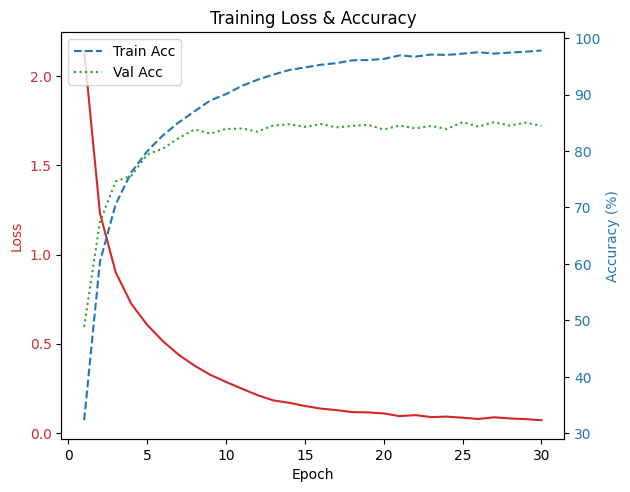

In [52]:
# plotting the loss and accuracy
fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy (%)", color="tab:blue")
ax2.plot(range(1, num_epochs + 1), train_accuracies, label="Train Acc", linestyle="--", color="tab:blue")
ax2.plot(range(1, num_epochs + 1), val_accuracies, label="Val Acc", linestyle=":", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:blue")

fig.tight_layout()
plt.title("Training Loss & Accuracy")
plt.legend()
plt.show()

In [57]:
# saving model down to a pkl file
torch.save(model.state_dict(), "quick_draw_model.pth")